In [1]:
import os
from sklearn.metrics import r2_score
import glob
from tqdm import tqdm
list_order_book_file_train = glob.glob('D:/Kaggle/optiver-realized-volatility-prediction/book_train.parquet/*')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [4]:
def log_return(stock_prices):
    return np.log(stock_prices).diff()

In [5]:
def realized_volatility_per_time_id(filepath,prediction_column_name):
    book_order = pd.read_parquet(filepath,engine='auto')
    book_order['wap'] = (book_order['bid_price1']*book_order['ask_size1'] + book_order['ask_price1']*book_order['bid_size1'])/(book_order['bid_size1'] + book_order['ask_size1'])
    book_order['log_returns'] = book_order.groupby(['time_id'])['wap'].apply(log_return)
    book_order = book_order[~book_order['log_returns'].isnull()]
    df_realized_vol_per_stock = pd.DataFrame(book_order.groupby(['time_id'])['log_returns'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_returns':prediction_column_name})
    stock_id = filepath.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

In [6]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in tqdm(list_file):
        df_past_realized = pd.concat([df_past_realized,realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

In [8]:
list_order_book_file_test = glob.glob('D:/Kaggle/optiver-realized-volatility-prediction/book_train.parquet/*')
df_naive_pred_test = past_realized_volatility_per_stock(list_file=list_order_book_file_test,prediction_column_name='target')


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:22<00:00,  1.81s/it]


In [9]:
train = pd.read_csv('D:/Kaggle/optiver-realized-volatility-prediction/train.csv')

In [10]:
train['row_id'] = train['stock_id'].astype(str)+'-'+ train['time_id'].astype(str)

In [11]:
df_naive_pred_test['pred_vol'] = df_naive_pred_test['target']

In [12]:
train = pd.merge(train[['target','row_id']],df_naive_pred_test[['row_id','pred_vol']],how = 'outer', on = 'row_id')

In [13]:
train = train[['row_id','pred_vol','target']]

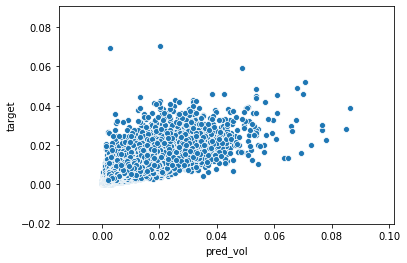

In [14]:
sns.scatterplot(train['pred_vol'],train['target'])

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [18]:
from sklearn.metrics import get_scorer,make_scorer
score = get_scorer("neg_mean_absolute_percentage_error")

In [21]:
model = LinearRegression()
score = cross_val_score(model,train['pred_vol'].to_numpy().reshape(-1,1),train['target'],cv=5,scoring = score)
score = -1*score.mean()
score

0.2467215454865757